In [41]:
import os
import shutil
import pathlib
# import joblib

# import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageOps, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import gridspec
# import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=FutureWarning)

random_seed = 0
# import tensorflow as tf
# tf.keras.utils.set_random_seed(random_seed) # Sets all random seeds for the program (Python, NumPy, and TensorFlow).

cmap_ref = 'nipy_spectral'

## 1.1 Load pictures <a class="anchor" id="load_pictures"></a> [⇪](#menu)

In [35]:
before_path = pathlib.Path('data', 'before_01.jpg')
after_path = pathlib.Path('data', 'after_01.jpg')

## 2.3 Pré-traitement des images sélectionnées <a class="anchor" id="prepa_preprocess"></a> [⇪](#menu)

#### On pré-traite les images, on crée un nouveau dossier pour les stocker et on les y copie

In [36]:
preprocessed_path = pathlib.Path('data', 'preprocessed')
os.mkdir(preprocessed_path)

In [37]:
def pre_processing(img_path, param_blur, newsize, name):

    img = Image.open(img_path)
    
    # Gray
    # gray_img = ImageOps.grayscale(img)
    
    # Blur
    # blured_img = gray_img.filter(ImageFilter.BoxBlur(param_blur))
    blured_img = img.filter(ImageFilter.BoxBlur(param_blur))
    
    # Equalize
    equalized_img = ImageOps.equalize(blured_img)
    
    # Resize
    final_img = equalized_img.resize(newsize)
    
    # Save image
    export_path = pathlib.Path(preprocessed_path, f"{name}.jpg")
    final_img.save(export_path)

    
    print(img_path, name.upper())
    fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
    #steps_show=[img, gray_img, blured_img, equalized_img, final_img]
    steps_show=[img, blured_img, equalized_img, final_img]
    steps_name=["source", "blured", "equalized", "resized"]
        
    spec = gridspec.GridSpec(
                    ncols=len(steps_show), nrows=2,
                    width_ratios=[1]*len(steps_show), wspace=0.3,
                    hspace=0.3, height_ratios=[5, 2]
                    )
        
    for i, image in enumerate(steps_show):

        fig.add_subplot(spec[i])
        plt.title(steps_name[i])
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

        fig.add_subplot(spec[i+len(steps_show)])
        mat = np.array(image)
        plt.title("Histogramme de l'image")
        plt.hist(mat.flatten(), bins=range(256))
        plt.xlabel('Intensité')
        plt.ylabel('Nombre de pixels')

    plt.show()

data/before_01.jpg BEFORE_01


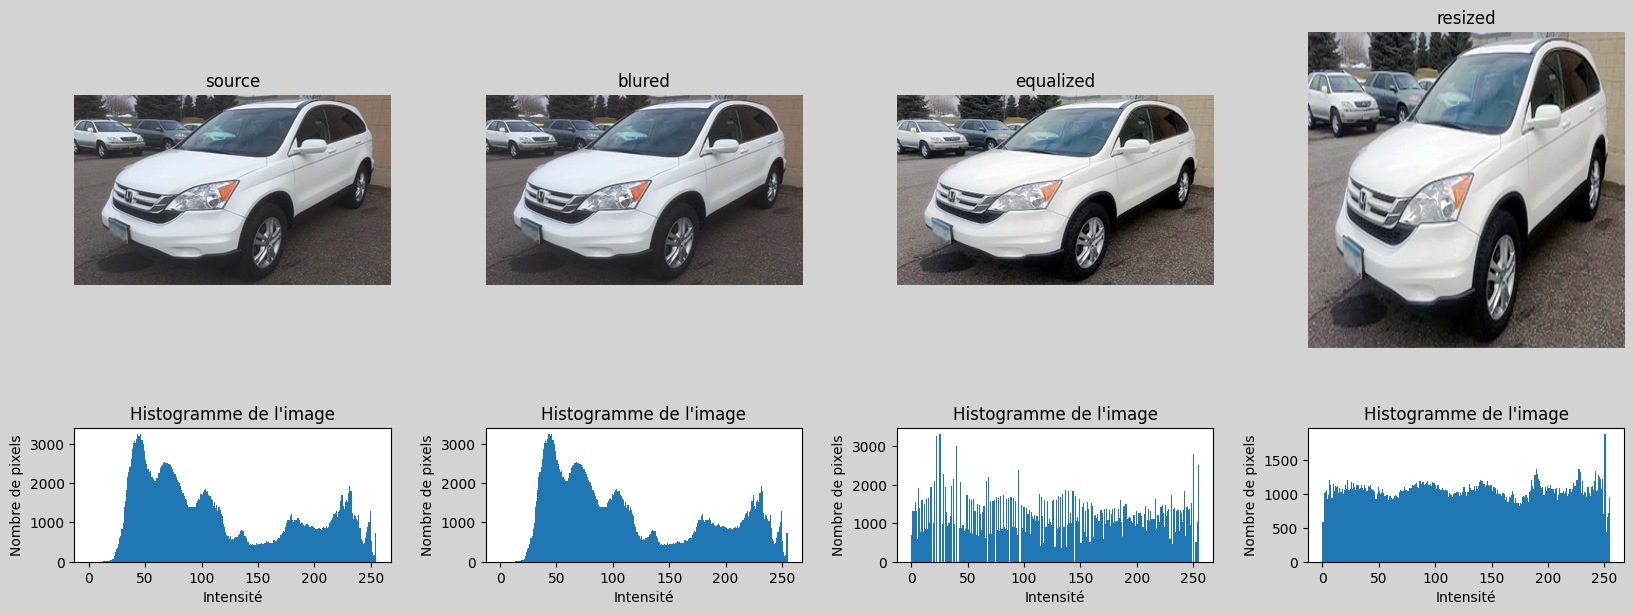

In [64]:
pre_processing(before_path, param_blur=0, newsize=(300,300), name="before_01")

data/after_01.jpg AFTER_01


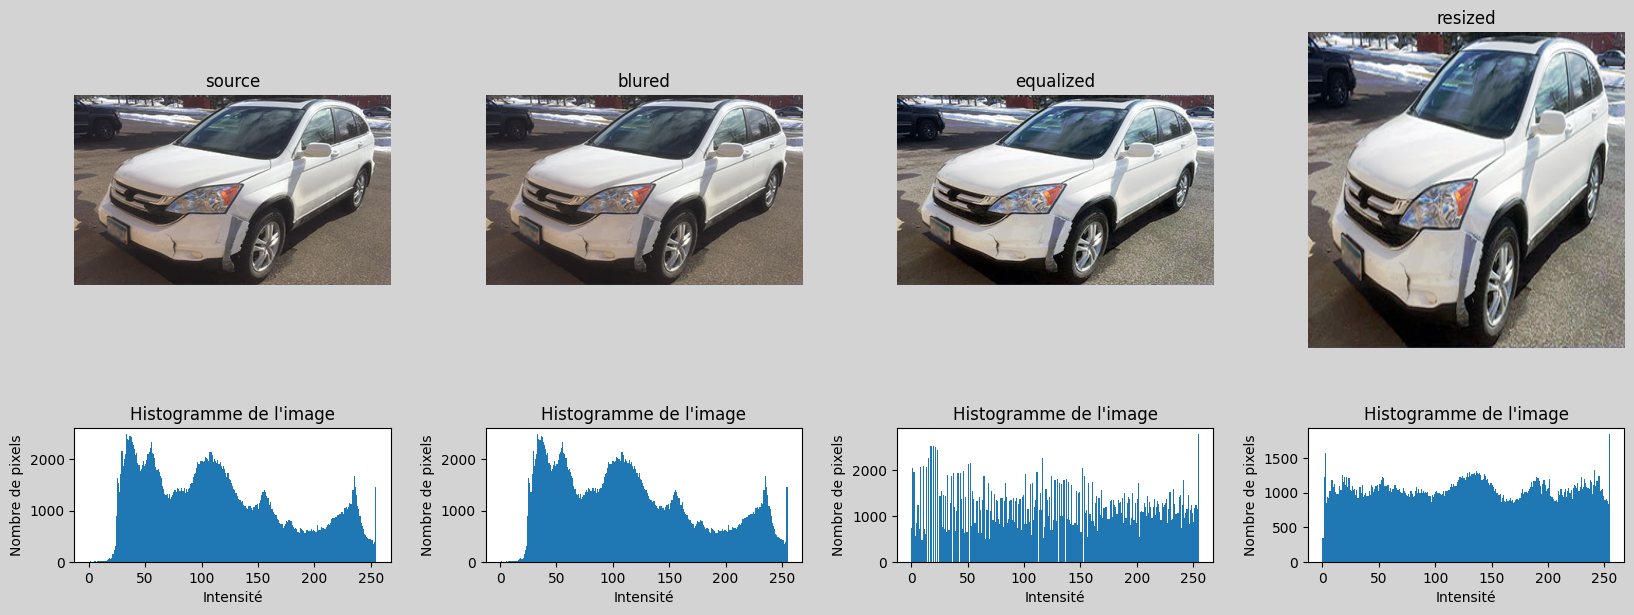

In [65]:
pre_processing(after_path, param_blur=0, newsize=(300,300), name="after_01")

L'**histogramme** d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. <br>Pour une image en noir et blanc, il indique en abscisse le niveau de gris (entier entre 0 et 255) et en ordonnée, le nombre de pixels ayant cette valeur.

Lorsque l'histogramme est **normalisé**, il indique en ordonnée la probabilité *(pi)* de trouver un pixel de niveau de gris *(i)* dans l'image. (ce n'est pas le cas ci-dessus)

Un **histogramme cumulé normalisé** calcule le pourcentage de pixels ayant une valeur inférieure à un niveau de gris donné. (ce n'est pas le cas ci-dessus)

---
---
# 3. Création **manuelle** des `bag of visual words` <a class="anchor" id="manual"></a> [⇪](#menu)

<img src="medias/bovw_process.jpeg" width="400">

## 3.1 Extraction de `features` et calcul des `descripteurs` des images <a class="anchor" id="manual_extract"></a> [⇪](#menu)

La première étape pour construire un `bag of visual words` est d'effectuer une extraction des features et de calculer les descripteurs pour chaque image du jeu de données. Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images. Pour faciliter cette étape de matching *(le k-means plus bas par exemple)*, le descripteur doit présenter de nombreuses propriétés d'invariance (rotation, échelle, illumination et dans une certaine mesure les variations affines). Ainsi, les descripteurs de deux features identiques à un changement géométrique ou photométrique près doivent donc être aussi proches que possible. L'étape de matching revient alors à comparer les descripteurs.

L'un des algorithmes les plus connus est `SIFT` *(Scale Invariant Feature Transform)*, mais il est existe d'autres comme `SURF` *(Spped Up Robust Feature)*, `BRIEF` *(Binary Robust Independent Elementary Features)* ou `ORB` *(ORiented BRIEF)*.
Ces algorithmes convertissent chaque patch en un vecteur à *n* dimensions et donc après cette étape, chaque image est une collection de vecteurs de la même dimension (128 pour SIFT), où l'ordre des différents vecteurs n'a pas d'importance.

<img src="medias/bovw_extract_features.png" width="400">

In [66]:
max_features = 500

# Initialize the ORB / SIFT detector algorithm
orb = cv2.ORB_create(nfeatures=max_features, patchSize=15)
sift = cv2.SIFT_create(nfeatures=max_features) # patchSize is fixed in code (size=12σ×12σ)

In [67]:
# data_photos_selection = pd.DataFrame()
#for label in data_photos.label.unique():
#    print(label)
#    data_photos_selection = pd.concat([data_photos_selection, data_photos[data_photos.label == label].sample(sample_size, random_state=random_seed)], axis=0)

data_photos_selection = ("before_01", "after_01")

0 before_01
data/preprocessed/before_01.jpg BEFORE_01


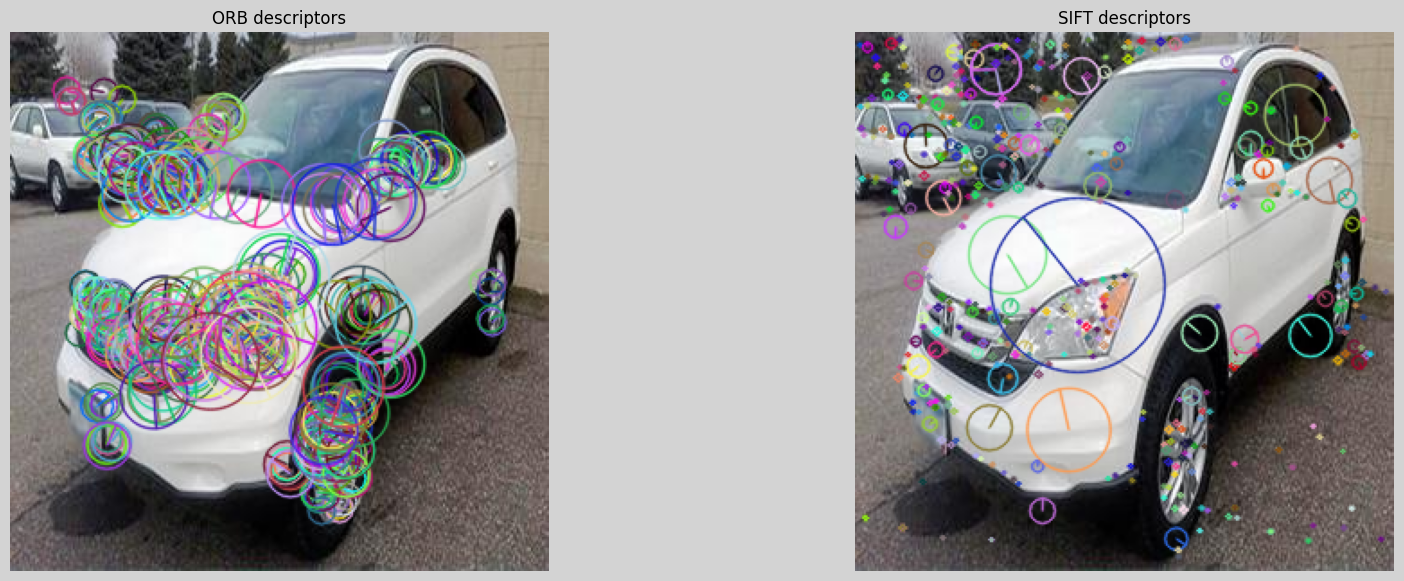

1 after_01
data/preprocessed/after_01.jpg AFTER_01


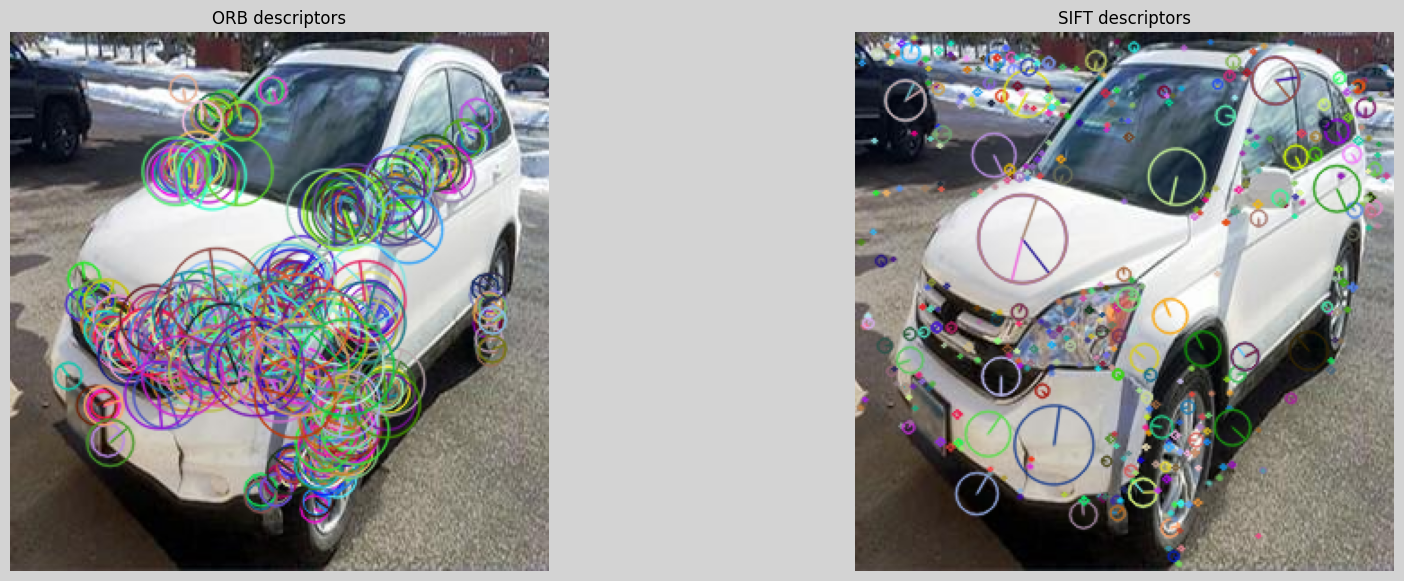

In [86]:
#sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
des_list_SIFT=[]
des_list_ORB_des=[]
des_list_ORB_kp=[]
imgs = []

for i, photo in enumerate(data_photos_selection):
    
    print(i, photo)

    img_path = pathlib.Path(preprocessed_path, f"{photo}.jpg")
    img = Image.open(img_path)
    imgs.append(img)
    
    # Detect the keypoints and compute the descriptors
    mat = np.array(img)
    queryKeypointsORB, queryDescriptorsORB = orb.detectAndCompute(mat,None)
    queryKeypointsSIFT, queryDescriptorsSIFT = sift.detectAndCompute(mat,None)
    
    #des_list_ORB.append((i, queryKeypointsORB, queryDescriptorsORB))
    #des_list_SIFT.append((i, queryKeypointsSIFT, queryDescriptorsSIFT))
    des_list_ORB_des.append((queryDescriptorsORB))
    des_list_ORB_kp.append((queryKeypointsORB))
    des_list_SIFT.extend(queryDescriptorsSIFT)
    
    print(img_path, photo.upper())
    fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
    # draw only keypoints location,not size and orientation
    plt.subplot(1,2,1)
    plt.title("ORB descriptors")
    #img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, color=(0,255,0), flags=0)
    img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_orb)
    plt.axis('off')
        
    plt.subplot(1,2,2)
    plt.title("SIFT descriptors")
    #img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, color=(0,255,0), flags=0)
    img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_sift)
    plt.axis('off')
        
    plt.show()

In [77]:
len(des_list_ORB)

2

In [78]:
des_list_ORB

[array([[170,  67, 110, ..., 125, 128, 166],
        [186,  98, 127, ...,  49, 130, 162],
        [250,  80,  33, ..., 177, 130,  35],
        ...,
        [182,  78, 232, ..., 252, 133,   3],
        [186,  80,  39, ...,  50, 194,  96],
        [120,  88, 129, ...,  20,  10, 107]], dtype=uint8),
 array([[248,  24,  33, ..., 177,   2,  97],
        [186, 114,  87, ...,  51, 138, 234],
        [250,  66, 105, ...,  49, 130,  35],
        ...,
        [248,  88, 129, ..., 178, 202,  97],
        [122,  66, 224, ..., 124, 131,  99],
        [219, 219,  57, ..., 177,   2, 165]], dtype=uint8)]

In [111]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [112]:
# Match descriptors.
matches = bf.match(des_list_ORB_des[0],des_list_ORB_des[1])

In [113]:
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [114]:
str(before_path)

'data/before_01.jpg'

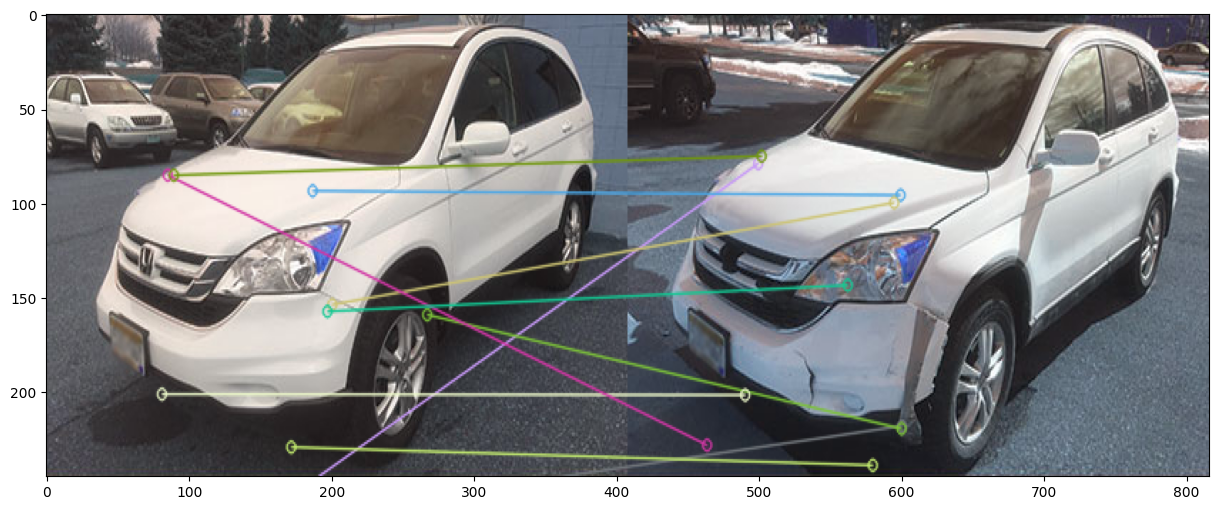

In [118]:
img1 = cv2.imread(str(before_path))
img2 = cv2.imread(str(after_path))

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,des_list_ORB_kp[0],img2,des_list_ORB_kp[1],matches[:10],None, flags=2)

plt.figure(figsize = (15,6))
plt.imshow(img3, aspect='auto')
plt.show()